In [28]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import Video
import nb_helpers

In [29]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

# FACE

## Fetch Image

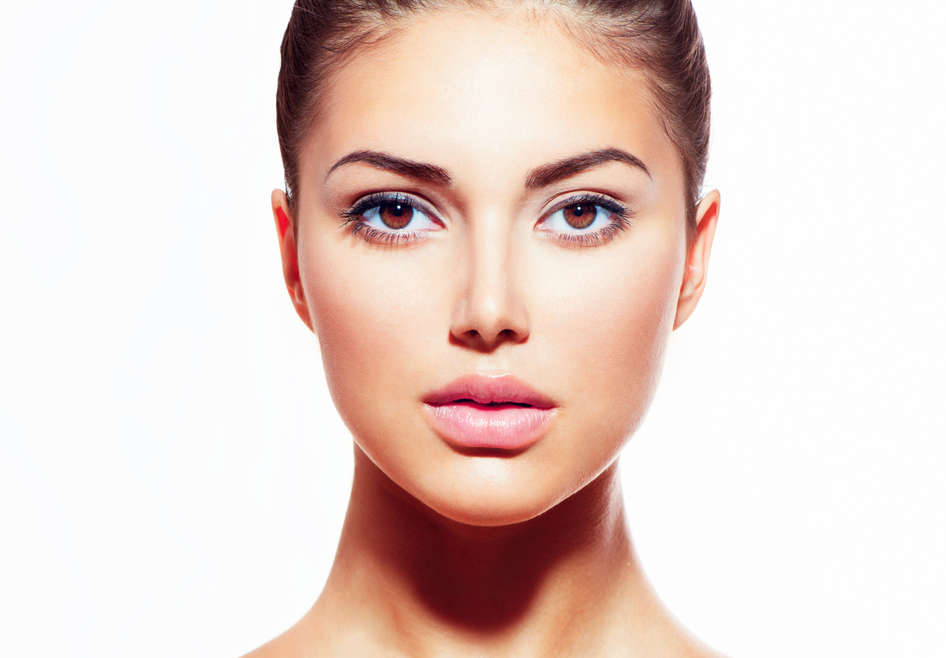

In [ ]:
 
img = Image.open('girl.png')
display(img)

In [31]:
file = 'girl.png'
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=1, color=[4, 244, 4])

# Create a face mesh object
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

    # Read image file with cv2 and convert from BGR to RGB
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

face_found = bool(results.multi_face_landmarks)

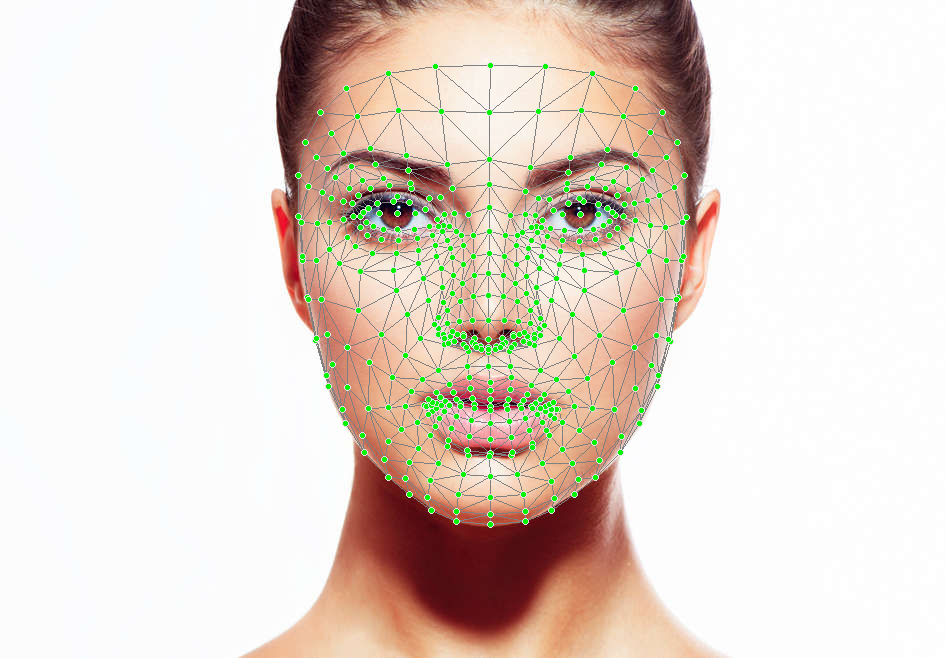

In [32]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
        
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        
    cv2.imwrite('face_tesselation_only.png', annotated_image)
    
img = Image.open('face_tesselation_only.png')
display(img)

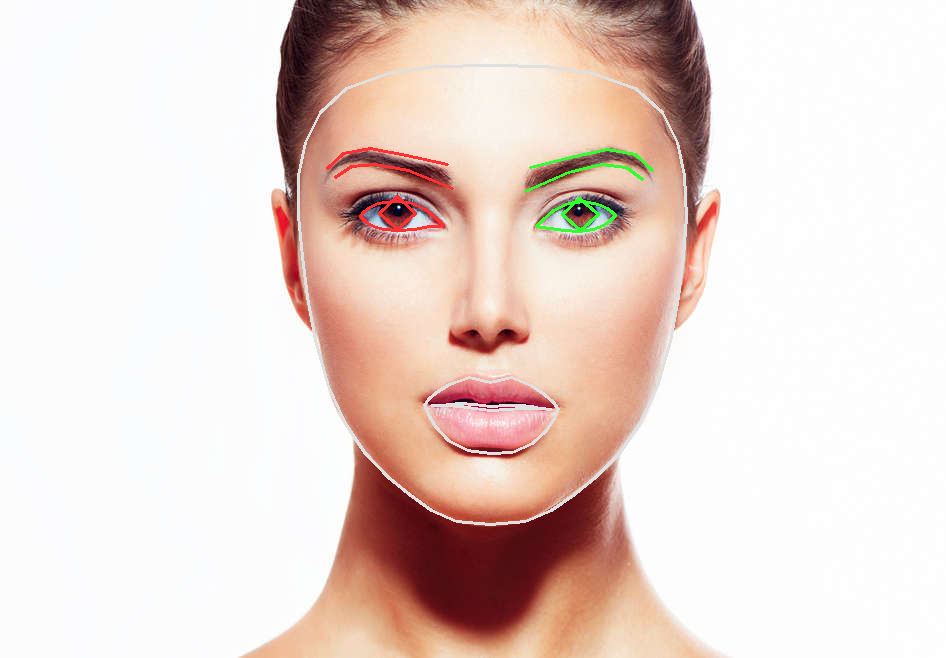

In [33]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
        
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())
                
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_iris_connections_style())

    cv2.imwrite('face_contours_and_irises.png', annotated_image)
    
img = Image.open('face_contours_and_irises.png')
display(img)

## Export Data

In [36]:
import urllib.request

url = "https://github.com/AssemblyAI-Examples/mediapipe-python/raw/main/face_blender.mp4"
urllib.request.urlretrieve(url, "face_blender.mp4")

from IPython.display import Video
Video("face_blender.mp4", height=480, embed=True)


In [37]:
import urllib.request

url = "https://github.com/AssemblyAI-Examples/mediapipe-python/raw/main/face_blender.mp4"
urllib.request.urlretrieve(url, "face_blender.mp4")

from IPython.display import Video
Video("face_blender.mp4", height=480, embed=True)


# Pose

In [38]:
# Fetch image for analysis
img_url = "https://static.turbosquid.com/Preview/2015/11/10__11_56_36/anthonystanding23dmetry3dhuman01.jpg5e774d4d-9b9e-456d-9d7b-fc4d741cf940Large.jpg"
urllib.request.urlretrieve(img_url, "pose.jpg")

('pose.jpg', <http.client.HTTPMessage at 0x1ce4a9d4750>)

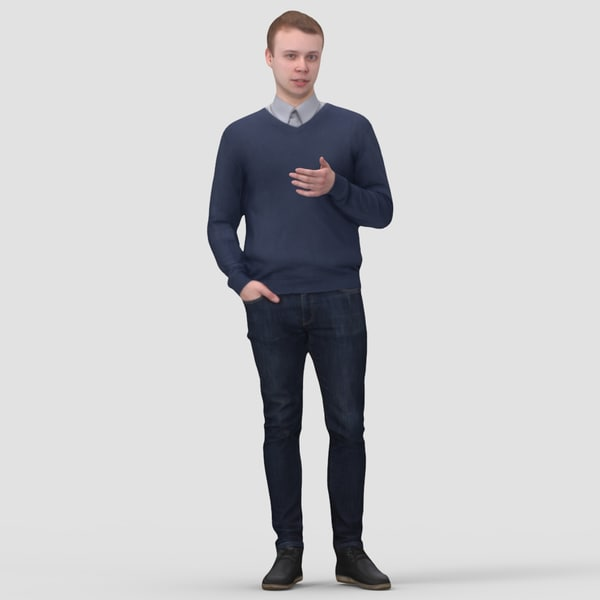

In [39]:
img = Image.open('pose.jpg')
display(img)

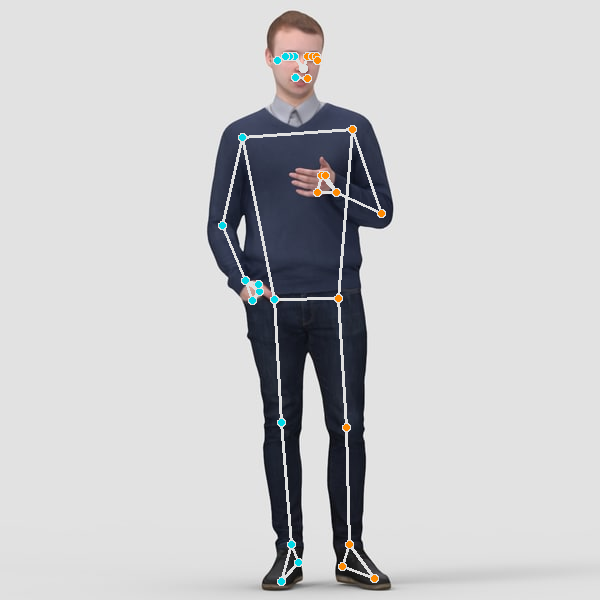

In [40]:
# Specify the image filename
file = 'pose.jpg'

# Create a MediaPipe `Pose` object
with mp_pose.Pose(static_image_mode=True,
                  model_complexity=2,
                  enable_segmentation=True) as pose:
        
    # Read the file in and get dims
    image = cv2.imread(file)

    # Convert the BGR image to RGB and then process with the `Pose` object.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Copy the iamge
annotated_image = image.copy()

# Draw pose, left and right hands, and face landmarks on the image with drawing specification defaults.
mp_drawing.draw_landmarks(annotated_image, 
                          results.pose_landmarks, 
                          mp_pose.POSE_CONNECTIONS,
                          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# Save image with drawing
filename = "pose_wireframe.png"
cv2.imwrite(filename, annotated_image)

# Open image
display(Image.open(filename))

## Segment Image

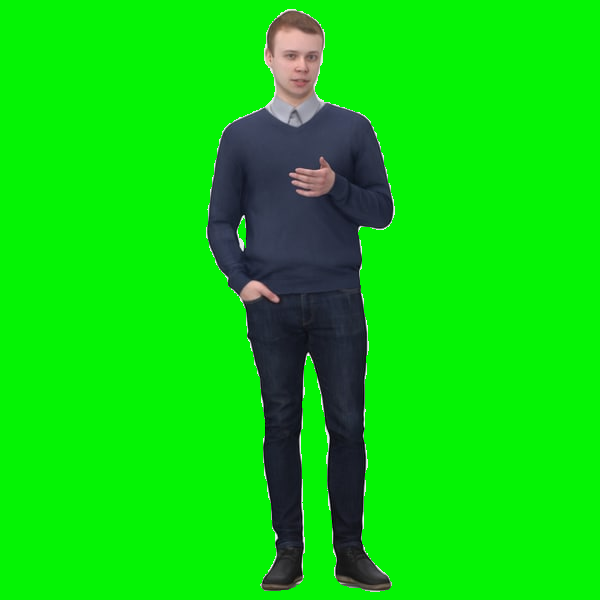

In [41]:
segmented_image = image.copy()

# Value in [0, 1] that says how "tight" to make the segmentation. Greater => tighter
tightness = .3

# Stacks the segmentation mask for 3 RGB channels, and then creates a filter for which pixels to keep
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > tightness

# Creates a black background image
bg_image = np.zeros(image.shape, dtype=np.uint8)

# Can change the color by specifying (0-255) RGB values below 
bg_image[:] = [4, 244, 4]

# Where the condition is met (i.e. above inclusion threshold), display annotated image
# Otherwise, use the background color
segmented_image = np.where(condition, segmented_image, bg_image)

filename = 'pose_green_screen.png'
cv2.imwrite(filename, segmented_image)
display(Image.open(filename))

# Exporting Data

In [42]:
poselandmarks_list = nb_helpers.poselandmarks_list

num = 0
for i in mp_holistic.POSE_CONNECTIONS:
    if num < 5:
        print(poselandmarks_list[i[0]], '-->', poselandmarks_list[i[1]])
    else:
        break
    num += 1

LEFT_WRIST --> LEFT_THUMB
RIGHT_WRIST --> RIGHT_INDEX
RIGHT_PINKY --> RIGHT_INDEX
LEFT_EYE_OUTER --> LEFT_EAR
RIGHT_ELBOW --> RIGHT_WRIST


In [43]:
# Pickle data as numpy array
data = np.empty((3, len(mp_holistic.PoseLandmark)))

landmarks = results.pose_world_landmarks.landmark
for i in range(len(mp_holistic.PoseLandmark)):
    data[:, i] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)            

In [44]:
#%matplotlib qt
%matplotlib inline

In [45]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

def rotate_and_save(figure, axis, filename, save=True):
    def update(angle):
        axis.view_init(30, angle)
        return figure,

    anim = FuncAnimation(figure, update, frames=range(0, 360), interval=50)

    if save:
        try:
            writer = FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
        except (RuntimeError, TypeError):
            writer = PillowWriter(fps=30)
        anim.save(filename, writer=writer, dpi=300)


In [23]:
from IPython.display import Video

Video("pose_rotation.mp4", width=500, embed=True, html_attributes="loop autoplay")


# Do with Video

In [46]:
url = 'https://github.com/AssemblyAI-Examples/mediapipe-python/blob/main/walking.mp4?raw=true'
urllib.request.urlretrieve(url, 'walking.mp4') 

('walking.mp4', <http.client.HTTPMessage at 0x1ce4a9d6810>)

In [47]:
file = 'walking.mp4'
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

    cap = cv2.VideoCapture(file)

    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    data = np.zeros((3, len(mp_pose.PoseLandmark), length))    
    

    frame_num = 0
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        landmarks = results.pose_world_landmarks.landmark
        for i in range(len(mp_pose.PoseLandmark)):
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)  
        
        frame_num += 1
                
    cap.release()
    #out.release()

In [48]:
data.shape


(3, 33, 144)

In [50]:
fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

anim = nb_helpers.time_animate(data, fig, ax)

# Save with fallback
try:
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
except (RuntimeError, TypeError):
    from matplotlib.animation import PillowWriter
    writer = PillowWriter(fps=30)


In [26]:
Video('walking_wireframe.mp4', width=500, html_attributes='loop autoplay')

We can view a side-by-side to see how it performs